In [26]:
%load_ext autoreload
%autoreload 2

In [27]:
from datetime import timedelta
import polars as pl
from tradedecomp.hdb import get_dataset
from tradedecomp.plots import plot_trades

# <font color="grey">Trade decomposition - explanation</font>

For illustration, we use a simple test dataset with only 10 rows. For simplicity, we omit price (```prc```) and quantity (```qty```) columns. Having the dates in datetime format is important for using the Polars time-based rolling methods, and having a ```trade_it``` columns is important for computing joins (they act as a kind of index column; time stamps don't work well for that since they can be duplicate).

In [12]:
df = pl.read_parquet("test_df.parquet")
print(df)

shape: (10, 3)
┌─────────────────────┬─────────┬──────────┐
│ ts                  ┆ product ┆ trade_id │
│ ---                 ┆ ---     ┆ ---      │
│ datetime[μs]        ┆ str     ┆ i64      │
╞═════════════════════╪═════════╪══════════╡
│ 2025-02-23 09:00:00 ┆ BTCUSDT ┆ 0        │
│ 2025-02-23 09:00:00 ┆ SOLUSDT ┆ 1        │
│ 2025-02-23 09:00:10 ┆ SOLUSDT ┆ 2        │
│ 2025-02-23 09:00:20 ┆ ETHUSDT ┆ 3        │
│ 2025-02-23 09:00:40 ┆ BTCUSDT ┆ 4        │
│ 2025-02-23 09:01:40 ┆ ETHUSDT ┆ 5        │
│ 2025-02-23 09:02:30 ┆ ETHUSDT ┆ 6        │
│ 2025-02-23 09:02:40 ┆ BTCUSDT ┆ 7        │
│ 2025-02-23 09:03:30 ┆ SOLUSDT ┆ 8        │
│ 2025-02-23 09:03:40 ┆ SOLUSDT ┆ 9        │
└─────────────────────┴─────────┴──────────┘


Given a $\delta>0$, the goal is to look for the presence of other trades in a $\delta$-neighbourhood of any given trade. Assume we have a trade in product ```prod``` with trade id ```id``` at time $t$. This leads to the following four cases:
* ```iso```: trade ```id``` is the only trade in $[t-\delta,t+\delta]$;
* ```nis-c```: the interval $[t-\delta,t+\delta]$ contains trades in other products but no trades ```prod``` other than ```id```;
* ```nis-s```: the interval $[t-\delta,t+\delta]$ contains trades in ```prod``` other than ```id``` in, but no trades for other products;
* ```nis-b```: the interval $[t-\delta,t+\delta]$ contains trades in other products and trades in product ```prod``` other than ```id```.

For the test dataset, we use $30$ seconds for $\delta$.

In [19]:
delta = timedelta(seconds=30)
products = df.select("product").unique().to_series().to_list()
print(products)

['BTCUSDT', 'SOLUSDT', 'ETHUSDT']


<font color="grey">**Count the number of trades**</font></a>

In a first step, we introduce a type of `one-hot' encoding for the products. We add a column for each products called ```{product}_flag``` that contains a $1$ if the corresponding row corresponds to a trade in ```product``` and $0$ otherwise.

In [18]:
df = df.with_columns([(pl.col("product") == prod).cast(pl.Int64).alias(f"{prod}_flag") for prod in products])
print(df)

shape: (10, 6)
┌─────────────────────┬─────────┬──────────┬──────────────┬──────────────┬──────────────┐
│ ts                  ┆ product ┆ trade_id ┆ BTCUSDT_flag ┆ ETHUSDT_flag ┆ SOLUSDT_flag │
│ ---                 ┆ ---     ┆ ---      ┆ ---          ┆ ---          ┆ ---          │
│ datetime[μs]        ┆ str     ┆ i64      ┆ i64          ┆ i64          ┆ i64          │
╞═════════════════════╪═════════╪══════════╪══════════════╪══════════════╪══════════════╡
│ 2025-02-23 09:00:00 ┆ BTCUSDT ┆ 0        ┆ 1            ┆ 0            ┆ 0            │
│ 2025-02-23 09:00:00 ┆ SOLUSDT ┆ 1        ┆ 0            ┆ 0            ┆ 1            │
│ 2025-02-23 09:00:10 ┆ SOLUSDT ┆ 2        ┆ 0            ┆ 0            ┆ 1            │
│ 2025-02-23 09:00:20 ┆ ETHUSDT ┆ 3        ┆ 0            ┆ 1            ┆ 0            │
│ 2025-02-23 09:00:40 ┆ BTCUSDT ┆ 4        ┆ 1            ┆ 0            ┆ 0            │
│ 2025-02-23 09:01:40 ┆ ETHUSDT ┆ 5        ┆ 0            ┆ 1            ┆ 0         

In a next step, we count the number of trades for each product in $[t-\delta,t+\delta]$. This is done by simply adding the ```{product}_flag``` columns in that interval around each time stamp and storing the result in new columns, called ```{product}_count```. In Polars, this is best done using [rolling windows](https://docs.pola.rs/api/python/stable/reference/dataframe/api/polars.DataFrame.rolling.html). 

In [20]:
df = df.with_columns(
    [pl.sum(f"{prod}_flag").rolling(
        index_column="ts",
        period=2*delta,
        offset=-delta,
        closed="both"
    ).alias(f"{prod}_count") 
    for prod in products]
)
print(df)

shape: (10, 9)
┌────────────┬─────────┬──────────┬────────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ ts         ┆ product ┆ trade_id ┆ BTCUSDT_fl ┆ … ┆ SOLUSDT_f ┆ BTCUSDT_c ┆ SOLUSDT_c ┆ ETHUSDT_c │
│ ---        ┆ ---     ┆ ---      ┆ ag         ┆   ┆ lag       ┆ ount      ┆ ount      ┆ ount      │
│ datetime[μ ┆ str     ┆ i64      ┆ ---        ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ s]         ┆         ┆          ┆ i64        ┆   ┆ i64       ┆ i64       ┆ i64       ┆ i64       │
╞════════════╪═════════╪══════════╪════════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 2025-02-23 ┆ BTCUSDT ┆ 0        ┆ 1          ┆ … ┆ 0         ┆ 1         ┆ 2         ┆ 1         │
│ 09:00:00   ┆         ┆          ┆            ┆   ┆           ┆           ┆           ┆           │
│ 2025-02-23 ┆ SOLUSDT ┆ 1        ┆ 0          ┆ … ┆ 1         ┆ 1         ┆ 2         ┆ 1         │
│ 09:00:00   ┆         ┆          ┆            ┆   ┆           ┆           ┆

For the classification, it is more convenient to not include the trade we are trying to classify in the trade count for that product. An easy way to achieve that is to subtract the indicator columns from the count columns. In Polars, one can do operations on columns without actually moving data by forming **expressions**. These expressions can then be included in ```.with_columns(expr)``` methods and all the operations involved are carried out in a very efficient way internally.

In [21]:
flag_columns = [pl.col(f"{prod}_flag")  for prod in products]
count_columns = [pl.col(f"{prod}_count") for prod in products]
adjusted_counts = [(count - flag).alias(f"{prod}_count") for count, flag, prod in zip(count_columns, flag_columns, products)]

df = df.with_columns(adjusted_counts)
print(df)

shape: (10, 9)
┌────────────┬─────────┬──────────┬────────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ ts         ┆ product ┆ trade_id ┆ BTCUSDT_fl ┆ … ┆ SOLUSDT_f ┆ BTCUSDT_c ┆ SOLUSDT_c ┆ ETHUSDT_c │
│ ---        ┆ ---     ┆ ---      ┆ ag         ┆   ┆ lag       ┆ ount      ┆ ount      ┆ ount      │
│ datetime[μ ┆ str     ┆ i64      ┆ ---        ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ s]         ┆         ┆          ┆ i64        ┆   ┆ i64       ┆ i64       ┆ i64       ┆ i64       │
╞════════════╪═════════╪══════════╪════════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 2025-02-23 ┆ BTCUSDT ┆ 0        ┆ 1          ┆ … ┆ 0         ┆ 0         ┆ 2         ┆ 1         │
│ 09:00:00   ┆         ┆          ┆            ┆   ┆           ┆           ┆           ┆           │
│ 2025-02-23 ┆ SOLUSDT ┆ 1        ┆ 0          ┆ … ┆ 1         ┆ 1         ┆ 1         ┆ 1         │
│ 09:00:00   ┆         ┆          ┆            ┆   ┆           ┆           ┆

Instead of counting the number of trades in each product, we are more interested in whether there are trades in the same product as the current product, and whether there are trades in a different product. For this, we introduce two additional columns: ```same_count``` and ```other_count```. For ```same_count```, we simply take the inner product of the ```flag``` entries in a row and the ```count``` entries. For example, in the first row this gives $(1,0,0) \cdot (0,2,1) = 0$, that is, there is no trade in the same product in a $\delta$ neighbourhood. For the ```other_count``` column, we just subtract ```same_count``` from the total number of counts (sum of the ```count``` columns). In Polars, suming across columns is done using the ```.sum_horizontal``` method. Once we have the ```same_count``` and ```other_count``` columns, we can drop the columns that are no longer needed.

In [23]:
product_exprs = [count * flag for count, flag in zip(count_columns, flag_columns)]

df = df.with_columns(
    pl.sum_horizontal(count_columns).alias("total_count")
).with_columns(
    pl.sum_horizontal(product_exprs).alias("same_count")
).with_columns(
    (pl.col("total_count")-pl.col("same_count")).alias("other_count")
).drop(count_columns + flag_columns + ["total_count"])
print(df)

shape: (10, 5)
┌─────────────────────┬─────────┬──────────┬────────────┬─────────────┐
│ ts                  ┆ product ┆ trade_id ┆ same_count ┆ other_count │
│ ---                 ┆ ---     ┆ ---      ┆ ---        ┆ ---         │
│ datetime[μs]        ┆ str     ┆ i64      ┆ i64        ┆ i64         │
╞═════════════════════╪═════════╪══════════╪════════════╪═════════════╡
│ 2025-02-23 09:00:00 ┆ BTCUSDT ┆ 0        ┆ 0          ┆ 3           │
│ 2025-02-23 09:00:00 ┆ SOLUSDT ┆ 1        ┆ 1          ┆ 2           │
│ 2025-02-23 09:00:10 ┆ SOLUSDT ┆ 2        ┆ 1          ┆ 3           │
│ 2025-02-23 09:00:20 ┆ ETHUSDT ┆ 3        ┆ 0          ┆ 4           │
│ 2025-02-23 09:00:40 ┆ BTCUSDT ┆ 4        ┆ 0          ┆ 2           │
│ 2025-02-23 09:01:40 ┆ ETHUSDT ┆ 5        ┆ 0          ┆ 0           │
│ 2025-02-23 09:02:30 ┆ ETHUSDT ┆ 6        ┆ 0          ┆ 1           │
│ 2025-02-23 09:02:40 ┆ BTCUSDT ┆ 7        ┆ 0          ┆ 1           │
│ 2025-02-23 09:03:30 ┆ SOLUSDT ┆ 8        ┆ 1   

<font color="grey">**Classify the trades**</font></a>

We are almost done. We just need to distingish the following four cases that can arise in the ```same_count``` and ```other_count``` columns:
* ```iso```: ```same_count```==0, ```other_count```==0
* ```nis-c```: ```same_count```==0, ```other_count```>0
* ```nis-s```: ```same_count```>0, ```other_count```==0
* ```nis-b```: ```same_count```>0, ```other_count```>0

In Polars, this can be done conveniently using the ```.when().then()``` methods. In our case, it can be conceptually simpler and (potentially) faster to view the four cases as a binary representation of the number $0$ to $3$, to convert these cases into such a number, and then map the code to a string label using a dictionary. If we agreed on a fixed numerical code for each of the four cases rather than insisting on adding the strings to a column, we could be even faster.

In [24]:
mapping = {"0": "iso", "1": "nis-c", "2": "nis-s", "3": "nis-b"}
df = df.with_columns(
    # Convert the four cases into a binary representation of the number 0 to 3
    (2 * (pl.col("same_count") > 0).cast(pl.Int8) +
    (pl.col("other_count") > 0).cast(pl.Int8)).cast(pl.Utf8).alias("trade_code")
).with_columns(
        pl.col("trade_code").replace(mapping).alias("trade_type")
).drop(["same_count", "other_count", "trade_code"])
print(df)

shape: (10, 4)
┌─────────────────────┬─────────┬──────────┬────────────┐
│ ts                  ┆ product ┆ trade_id ┆ trade_type │
│ ---                 ┆ ---     ┆ ---      ┆ ---        │
│ datetime[μs]        ┆ str     ┆ i64      ┆ str        │
╞═════════════════════╪═════════╪══════════╪════════════╡
│ 2025-02-23 09:00:00 ┆ BTCUSDT ┆ 0        ┆ nis-c      │
│ 2025-02-23 09:00:00 ┆ SOLUSDT ┆ 1        ┆ nis-b      │
│ 2025-02-23 09:00:10 ┆ SOLUSDT ┆ 2        ┆ nis-b      │
│ 2025-02-23 09:00:20 ┆ ETHUSDT ┆ 3        ┆ nis-c      │
│ 2025-02-23 09:00:40 ┆ BTCUSDT ┆ 4        ┆ nis-c      │
│ 2025-02-23 09:01:40 ┆ ETHUSDT ┆ 5        ┆ iso        │
│ 2025-02-23 09:02:30 ┆ ETHUSDT ┆ 6        ┆ nis-c      │
│ 2025-02-23 09:02:40 ┆ BTCUSDT ┆ 7        ┆ nis-c      │
│ 2025-02-23 09:03:30 ┆ SOLUSDT ┆ 8        ┆ nis-s      │
│ 2025-02-23 09:03:40 ┆ SOLUSDT ┆ 9        ┆ nis-s      │
└─────────────────────┴─────────┴──────────┴────────────┘


In order to check if this gave the correct results, we can visualize this.

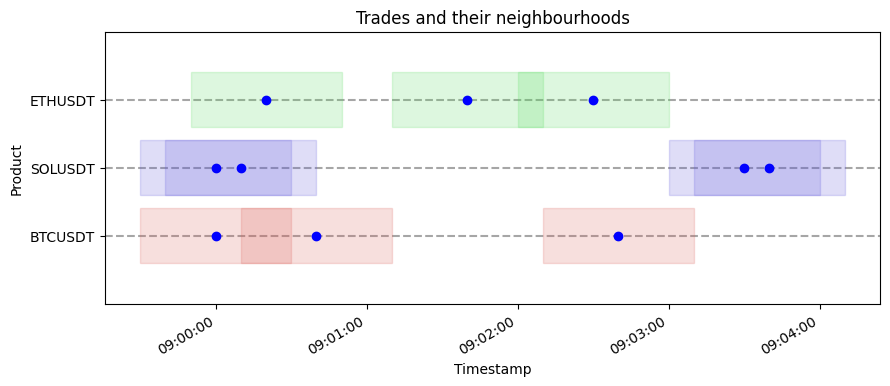

In [30]:
plot_trades(df, products, 'ts', '250223.090000', 10, '30s')

<font color="grey">**Test on real dataset**</font></a>

The above sequence has been implemented as ```label_trades``` function, and included as Python extension. To use it, one should first load the data using the dataloader, add a datetime column and (optionally) aggregate trades that occur in the same product at the same timestamp. 

In [32]:
dl = get_dataset("tardis")

Let's pick $20$ days in August. When not using lazy mode, the loading may take a while. However, due to internal caching we have to load it only once per session. Alternatively, we can use lazy mode and only load the data when needed using collect.

In [33]:
# Now for some real data
df = dl.load_trades(products, ['240801.0800', '240820.2000'])._trade.agg_trades()._dt.add_datetime('ts')

In [34]:
tdf = df._trade.classify_trades(products, "dts", "5ms")
tdf.head()

ts,prc,product,trade_id,qty,dts,trade_type
u64,f64,str,u64,f64,datetime[ns],str
1722499201177500000,64297.5,"""BTCUSDT""",5221055242,0.058,2024-08-01 08:00:01.177500,"""iso"""
1722499202943500000,64297.4,"""BTCUSDT""",5221055243,-0.003,2024-08-01 08:00:02.943500,"""iso"""
1722499202956500000,168.161,"""SOLUSDT""",1691842477,7.0,2024-08-01 08:00:02.956500,"""nis-c"""
1722499202957500000,64297.5,"""BTCUSDT""",5221055244,0.147,2024-08-01 08:00:02.957500,"""nis-b"""
1722499202958500000,64297.4,"""BTCUSDT""",5221055245,-0.002,2024-08-01 08:00:02.958500,"""nis-b"""
